In [1]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers

from sklearn.utils import shuffle

import numpy.random as rng
import matplotlib.pyplot as plt

In [2]:
train_folder = "./images_background/"
val_folder = './images_evaluation/'
save_path = './data'

In [3]:
def loadimgs(path,n = 0):
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.array(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.array(y)
    X = np.array(X)
    return X,y,lang_dict

### Loading the train images into tensors

In [24]:
X,y,c=loadimgs(train_folder)
X.shape

loading alphabet: Korean
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: N_Ko
loading alphabet: Bengali
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Early_Aramaic
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Cyrillic
loading alphabet: Tagalog
loading alphabet: Sanskrit
loading alphabet: Burmese_(Myanmar)
loading alphabet: Hebrew
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tifinagh
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Greek
loading alphabet: Latin
loading alphabet: Futurama
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Braille
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Grantha
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Gujarati


(964, 20, 105, 105)

### Saving the train tensors on disk

In [25]:
with open("./pickles/train.pickle", "wb") as f:
    pickle.dump((X,c),f)

### Loading the validation images into tensors

In [26]:
Xval,yval,cval=loadimgs(val_folder)
Xval.shape

loading alphabet: Glagolitic
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Aurek-Besh
loading alphabet: Manipuri
loading alphabet: ULOG
loading alphabet: Atlantean
loading alphabet: Avesta
loading alphabet: Gurmukhi
loading alphabet: Malayalam
loading alphabet: Atemayar_Qelisayer
loading alphabet: Tengwar
loading alphabet: Sylheti
loading alphabet: Tibetan
loading alphabet: Ge_ez
loading alphabet: Keble
loading alphabet: Mongolian
loading alphabet: Syriac_(Serto)
loading alphabet: Kannada
loading alphabet: Oriya
loading alphabet: Angelic


(659, 20, 105, 105)

### Saving the validation tensors on disk

In [27]:
with open("pickles/val.pickle", "wb") as f:
    pickle.dump((Xval,cval),f)

In [14]:
# del X, y ,c ,Xval, yval, cval

In [4]:
def initialize_weights(shape, name=None, dtype = None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [5]:
def initialize_bias(shape, name=None, dtype = None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [6]:
def get_siamese_model(input_shape):
    # Define the tensors for the two input images
    left_input = layers.Input(input_shape)
    right_input = layers.Input(input_shape)
    
    # Convolutional Neural Network
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='sigmoid',
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = layers.Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = tf.keras.models.Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [7]:
model = get_siamese_model((105, 105, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[1][0]             

In [8]:
optimizer = tf.keras.optimizers.Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

# Loading training and validation data

In [9]:
with open("pickles/train.pickle", "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Korean', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'N_Ko', 'Bengali', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Early_Aramaic', 'Asomtavruli_(Georgian)', 'Balinese', 'Cyrillic', 'Tagalog', 'Sanskrit', 'Burmese_(Myanmar)', 'Hebrew', 'Syriac_(Estrangelo)', 'Tifinagh', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Mkhedruli_(Georgian)', 'Greek', 'Latin', 'Futurama', 'Anglo-Saxon_Futhorc', 'Braille', 'Malay_(Jawi_-_Arabic)', 'Grantha', 'Arcadian', 'Armenian', 'Alphabet_of_the_Magi', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Gujarati']


In [10]:
with open("pickles/val.pickle", "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Glagolitic', 'Old_Church_Slavonic_(Cyrillic)', 'Aurek-Besh', 'Manipuri', 'ULOG', 'Atlantean', 'Avesta', 'Gurmukhi', 'Malayalam', 'Atemayar_Qelisayer', 'Tengwar', 'Sylheti', 'Tibetan', 'Ge_ez', 'Keble', 'Mongolian', 'Syriac_(Serto)', 'Kannada', 'Oriya', 'Angelic']


In [11]:
Xtrain = Xtrain.astype('float16')
Xval = Xval.astype('float16')

In [12]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [13]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [14]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [15]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [16]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(save_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 2.0025741338729857 mins
Train Loss: 0.2850838303565979
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 39.6% 20 way one-shot learning accuracy 

Current best: 39.6, previous best: -1

 ------------- 

Time for 400 iterations: 4.45616641441981 mins
Train Loss: 0.3060914874076843
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 42.0% 20 way one-shot learning accuracy 

Current best: 42.0, previous best: 39.6

 ------------- 

Time for 600 iterations: 6.8983766277631124 mins
Train Loss: 0.3244188129901886
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 53.6% 20 way one-shot learning accuracy 

Current best: 53.6, previous best: 42.0

 ------------- 

Time for 800 iterations: 9.331849014759063 mins
Train Loss: 0.15204691886901855
Evaluating model on 250 random 20 way one-s

In [ ]:
# Save the model architecture
with open('./finalModel/oneshot_architecture.json', 'w') as f:
    f.write(model.to_json())

#Save optimal weights
model.save_weights('./finalModel/oneshot_weights.h5')

model.save('./finalModel/SCNN.h5')

### Load model weights

In [19]:
model.load_weights(os.path.join(save_path, "weights.4400.h5"))

In [20]:
model(make_oneshow_task(1))

NameError: name 'make_oneshow_task' is not defined

In [23]:
train_classes

{'Alphabet_of_the_Magi': [0, 19],
 'Anglo-Saxon_Futhorc': [20, 48],
 'Arcadian': [49, 74],
 'Armenian': [75, 115],
 'Asomtavruli_(Georgian)': [116, 155],
 'Balinese': [156, 179],
 'Bengali': [180, 225],
 'Blackfoot_(Canadian_Aboriginal_Syllabics)': [226, 239],
 'Braille': [240, 265],
 'Burmese_(Myanmar)': [266, 299],
 'Cyrillic': [300, 332],
 'Early_Aramaic': [333, 354],
 'Futurama': [355, 380],
 'Grantha': [381, 423],
 'Greek': [424, 447],
 'Gujarati': [448, 495],
 'Hebrew': [496, 517],
 'Inuktitut_(Canadian_Aboriginal_Syllabics)': [518, 533],
 'Japanese_(hiragana)': [534, 585],
 'Japanese_(katakana)': [586, 632],
 'Korean': [633, 672],
 'Latin': [673, 698],
 'Malay_(Jawi_-_Arabic)': [699, 738],
 'Mkhedruli_(Georgian)': [739, 779],
 'N_Ko': [780, 812],
 'Ojibwe_(Canadian_Aboriginal_Syllabics)': [813, 826],
 'Sanskrit': [827, 868],
 'Syriac_(Estrangelo)': [869, 891],
 'Tagalog': [892, 908],
 'Tifinagh': [909, 963]}

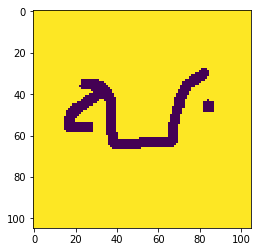

In [24]:
plt.imshow(Xtrain[0][1])

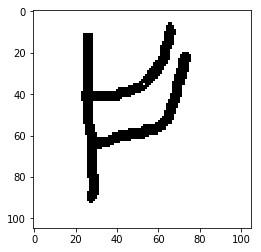

In [30]:
plt.imshow(Xtrain[20,1,:,:],cmap = 'gray')

In [21]:
with open("./pickles/lang_dic.pickle","rb")as f:
    img_dic = pickle.load(f)
    
     
    #img_dic = np.stack(img_dic)
    
def make_oneshot_pairs(current_image,language):
    N = len(img_dic[language])
    test_image = np.asarray([current_image]*N)
    test_image  = test_image.reshape(N, 105, 105,1)
    support_set = img_dic[language].reshape(N, 105, 105,1)
    pairs = [test_image,support_set]
    return pairs

input = make_oneshot_pairs(Xtrain[0,0,:,:],"Futurama") 
input

ValueError: cannot reshape array of size 2 into shape (2,105,105,1)

5
99.44


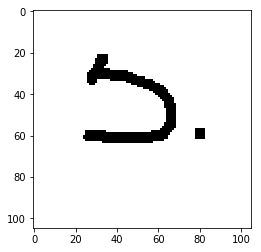

In [32]:
predictions = model.predict( make_oneshot_pairs(Xtrain[5,2,:,:],"Alphabet_of_the_Magi") )
pin = np.argmax(predictions)
print(pin)
acc = np.max(predictions)*100
print(round(acc,2))
plt.imshow(img_dic["Alphabet_of_the_Magi"][pin],cmap = 'gray')